Using these datasets:

https://opendatakingston.cityofkingston.ca/explore/dataset/transit-gtfs-routes/export/?disjunctive.route_short_name - Transit Routes
https://opendatakingston.cityofkingston.ca/explore/dataset/driveways/information/?disjunctive.material - driveways

In [2]:
import pandas as pd
import json
import folium
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [3]:
driveways = pd.read_csv("driveways.csv")
routes = pd.read_csv("transit-gtfs-routes.csv")

In [4]:
coordinates = []

for index, row in routes.iterrows():
    try:
        shape = routes.iloc[index]['Shape']
        shape = json.loads(shape)['coordinates']
        shape = [(y, x) for [x, y] in shape[0]]
        coordinates.append(shape)
    except:
        pass

print(coordinates[0])

[(44.27897, -76.47257), (44.27871, -76.47265), (44.27855, -76.47309), (44.27862, -76.47343), (44.27759, -76.47388), (44.27666, -76.4743), (44.27571, -76.47497), (44.27462, -76.47609), (44.27379, -76.4769), (44.27302, -76.47762), (44.27124, -76.47887), (44.2706, -76.47929), (44.27002, -76.47941), (44.26857, -76.47912), (44.26807, -76.47914), (44.26627, -76.4786), (44.26517, -76.47841), (44.26424, -76.4785), (44.26391, -76.47869), (44.26375, -76.47866), (44.26329, -76.47896), (44.2624, -76.47993), (44.26166, -76.48075), (44.25966, -76.48179), (44.25859, -76.48227), (44.25724, -76.4829), (44.25629, -76.48305), (44.25616, -76.48317), (44.25574, -76.48305), (44.25493, -76.48324), (44.25348, -76.48446), (44.25268, -76.48522), (44.25251, -76.48525), (44.25233, -76.48535), (44.25015, -76.48577), (44.24823, -76.48681), (44.2477, -76.48709), (44.24582, -76.48747), (44.24466, -76.48758), (44.24287, -76.48785), (44.24191, -76.48775), (44.24134, -76.48762), (44.24109, -76.48747), (44.24026, -76.486

In [5]:
colors = ['lightred', 'darkpurple', 'orange', 'darkblue', 'darkred', 'pink', 'lightgreen', 'gray', 'darkgreen', 'beige', 'lightblue', 'cadetblue', 'green', 'red', 'purple', 'white', 'black', 'lightgray', 'blue']

map = folium.Map(location=(coordinates[0][0][0], coordinates[0][0][1]))
for i, coord in enumerate(coordinates):
    folium.PolyLine(coord, color=colors[i%len(colors)]).add_to(map)
map


In [6]:
driveway_list = []
driveways['geo_point_2d'] = driveways['geo_point_2d'].astype(str)
# print(driveways.iloc[0]['geo_point_2d'].split(', '))

for index, row in driveways.iterrows():
    try:
        cur_list = driveways.iloc[index]['geo_point_2d'].split(', ')
        driveway_list.append((float(cur_list[0]), float(cur_list[1])))
    except:
        pass
print(driveway_list[0])

(44.237419941371535, -76.62266778529843)


In [34]:
#distance from each driveway to closest bus stop
from math import radians, cos, sin, sqrt, atan2

driveway_to_bus = pd.DataFrame(columns=['driveway_long', "driveway_lat", 'bus_stop_long', 'bus_stop_lat', 'distance'])

def haversine(coord1, coord2):
    R = 6371  # radius of Earth in kilometers
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    distance = R * c
    return distance

for k, driveway in enumerate(driveway_list):
    min_dist = 100000
    closest_bus_stop = None
    for coord in coordinates: #array of tuples
        for i in range(len(coord)-1): #each tuple is a coordinate
            dist = haversine(driveway, coord[i])
            if dist < min_dist:
                closest_bus_stop = coord[i]
                min_dist = dist
    driveway_to_bus.loc[k] = [driveway[0], driveway[1], closest_bus_stop[0], closest_bus_stop[1], min_dist]

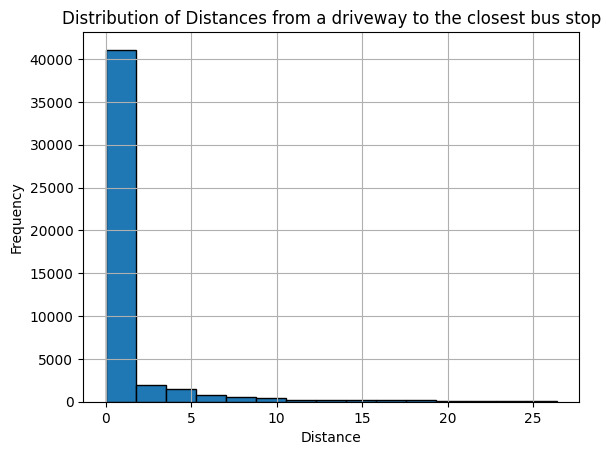

In [8]:
driveway_to_bus['distance'].hist(bins=15, edgecolor='black')
plt.title('Distribution of Distances from a driveway to the closest bus stop')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

As we can see, the vast majority of people are within 1km of the nearest bus stop. Let's assume that anybody more than 1.5km from a bus stop is not going to use the bus.

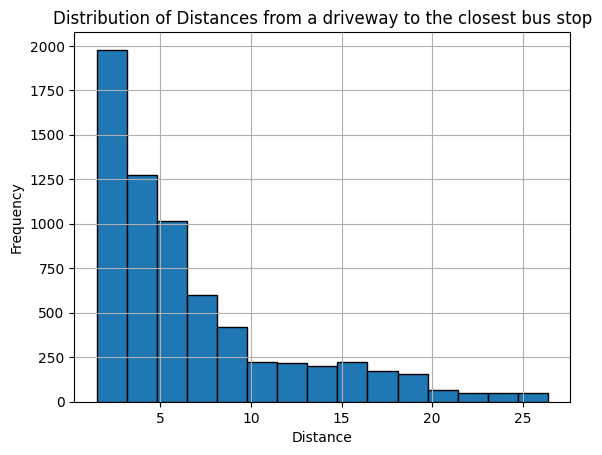

In [35]:
far_driveways = driveway_to_bus[driveway_to_bus['distance'] > 1.5]
far_driveways['distance'].hist(bins=15, edgecolor='black')
plt.title('Distribution of Distances from a driveway to the closest bus stop')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

In [10]:
far_driveways['distance'].describe()

count    6696.000000
mean        6.760925
std         5.316674
min         1.501850
25%         2.701754
50%         4.903498
75%         8.735961
max        26.378521
Name: distance, dtype: float64

Let's find out how many driveways are within 1.5km of any given driveway.

In [36]:
from sklearn.neighbors import KDTree
import numpy as np

# Convert driveway coordinates to a 2D numpy array
coords = far_driveways[['driveway_long', 'driveway_lat']].values

# Create a KDTree from the coordinates
tree = KDTree(coords)

# Define a function to count the number of driveways within 1km
def count_close_driveways(row):
    indices = tree.query_radius([(row['driveway_long'], row['driveway_lat'])], r=1.5/111.1)
    return len(indices[0]) - 1  # Subtract 1 to exclude the driveway itself

# Apply the function to each row
far_driveways['close_driveways'] = far_driveways.apply(count_close_driveways, axis=1)

/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/1538059938.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  far_driveways['close_driveways'] = far_driveways.apply(count_close_driveways, axis=1)


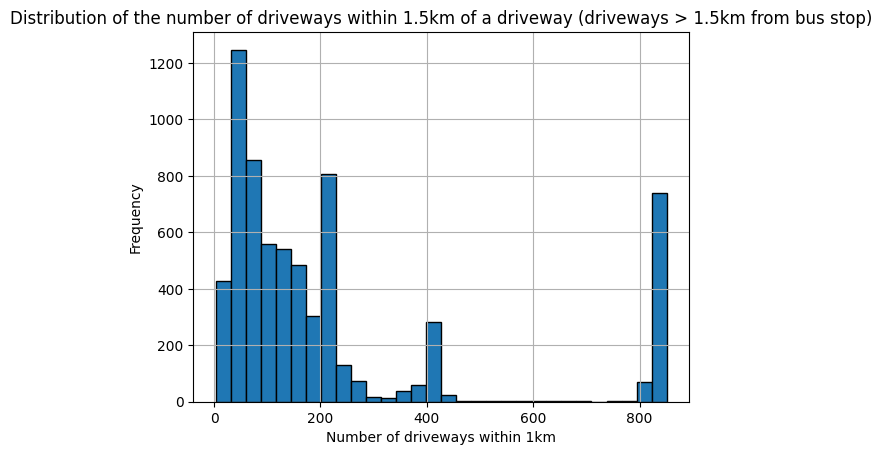

In [13]:
far_driveways['close_driveways'].hist(bins=30, edgecolor='black')
plt.title('Distribution of the number of driveways within 1.5km of a driveway (driveways > 1.5km from bus stop)')
plt.xlabel('Number of driveways within 1km')
plt.ylabel('Frequency')
plt.show()

In [513]:
far_driveways['close_driveways'].describe()

count    6696.000000
mean      219.620370
std       247.433396
min         3.000000
25%        59.000000
50%       129.000000
75%       221.000000
max       851.000000
Name: close_driveways, dtype: float64

Here, we can see that the majority of people more than 1.5 km from a bus stop, don't have too many other driveways in their area, with a mean of 219 driveways within 1.5km, and median of 129. Let's see how many bus stops we'll need to add to get the majority of people within 1.5km of a bus stop. Let's compare that with everybody else.

/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/1013984417.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_driveways['close_driveways'] = close_driveways.apply(count_close_driveways, axis=1)


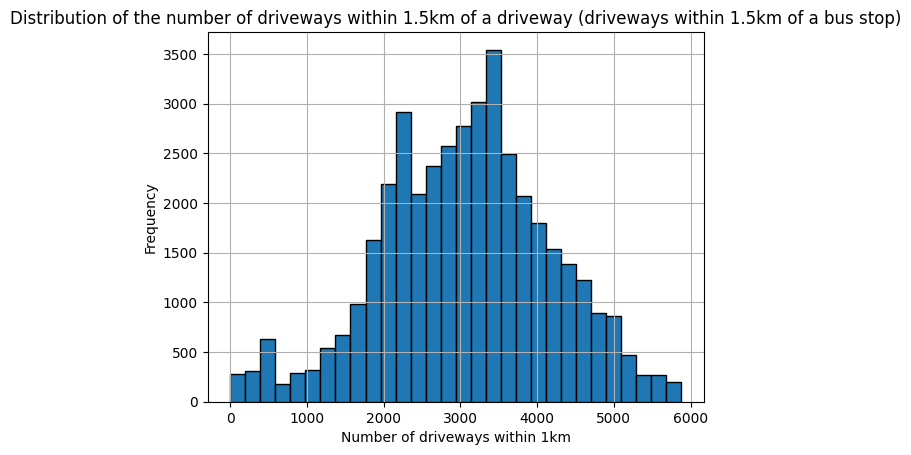

In [14]:
close_driveways = driveway_to_bus[driveway_to_bus['distance'] <= 1.5]
coords = close_driveways[['driveway_long', 'driveway_lat']].values

# Create a KDTree from the coordinates
tree = KDTree(coords)

# Define a function to count the number of driveways within 1km
def count_close_driveways(row):
    indices = tree.query_radius([(row['driveway_long'], row['driveway_lat'])], r=1.5/111.1)
    return len(indices[0]) - 1  # Subtract 1 to exclude the driveway itself

# Apply the function to each row
close_driveways['close_driveways'] = close_driveways.apply(count_close_driveways, axis=1)

close_driveways['close_driveways'].hist(bins=30, edgecolor='black')
plt.title('Distribution of the number of driveways within 1.5km of a driveway (driveways within 1.5km of a bus stop)')
plt.xlabel('Number of driveways within 1km')
plt.ylabel('Frequency')
plt.show()

In [14]:
close_driveways['close_driveways'].describe()

count    40790.000000
mean      3069.119343
std       1107.348147
min          1.000000
25%       2296.250000
50%       3108.500000
75%       3795.000000
max       5878.000000
Name: close_driveways, dtype: float64

As we can see, this is almost perfectly normally distributed, with a mean of 3069, and median of 3108. It makes a lot of sense that these houses have more accessible public transportation, as it can be much more efficient in these dense areas.

In [16]:
far_driveways_temp = far_driveways.sort_values(by='close_driveways', ascending=False).reset_index(drop=True)
new_stops = []
indices_to_drop = []
while ((far_driveways_temp['distance'] > 1.5).sum()) > 0:
    tree = KDTree(far_driveways_temp[['driveway_long', 'driveway_lat']].values)
    new_stops.append((far_driveways_temp.iloc[0]['driveway_long'], far_driveways_temp.iloc[0]['driveway_lat']))
    indices, distances = tree.query_radius([(far_driveways_temp.iloc[0]['driveway_long'], far_driveways_temp.iloc[0]['driveway_lat'])], r=1.5/111.1, return_distance=True)

    far_driveways_temp.drop(indices[0], inplace=True)
    far_driveways_temp.reset_index(drop=True, inplace=True)

print(len(new_stops))

151


In [18]:
map = folium.Map(location=(new_stops[0][0], new_stops[0][1]))
for new_stop in new_stops:
    folium.Marker(new_stop).add_to(map)
map

I think the one in the bottom left by the airport may cause us some trouble, so let's see how many driveways are within 1.5km of that one, and if it's not a lot, we'll remove it. It's the one with the highest longitude.

In [19]:
#long/lat = 44.216106, -76.600392

far_driveways = far_driveways.sort_values(by='driveway_long', ascending=True).reset_index(drop=True)
far_driveways.head()

far_driveways.loc[np.isclose(far_driveways['driveway_long'], 44.2161059081, atol=1e-10) & np.isclose(far_driveways['driveway_lat'], -76.6003917575, atol=1e-10)]

,driveway_long,driveway_lat,bus_stop_long,bus_stop_lat,distance,close_driveways
2,44.216106,-76.600392,44.22944,-76.5913,1.650221,14
3,44.216120,-76.600743,44.22944,-76.5913,1.661325,14


As we can see, there are only 14 driveways close to it, so lets remove it. It's also only 1.65km away from the nearest bus stop, so they can walk.

In [20]:
new_stops = sorted(new_stops, key=lambda x: x[0])
new_stops = new_stops[1:]

In [21]:
#DO NOT RUN, OVERWRITES DATA. ONLY FOR VISUALIZING THAT THE NEW STOPS ARE CORRECT

all_routes = coordinates + [new_stops]

for k, driveway in enumerate(driveway_list):
    min_dist = 100000
    closest_bus_stop = None
    for coord in all_routes: #array of tuples
        for i in range(len(coord)-1):
            dist = haversine(driveway, coord[i])
            if dist < min_dist:
                closest_bus_stop = coord[i]
                min_dist = dist
    driveway_to_bus.loc[k] = [driveway[0], driveway[1], closest_bus_stop[0], closest_bus_stop[1], min_dist]

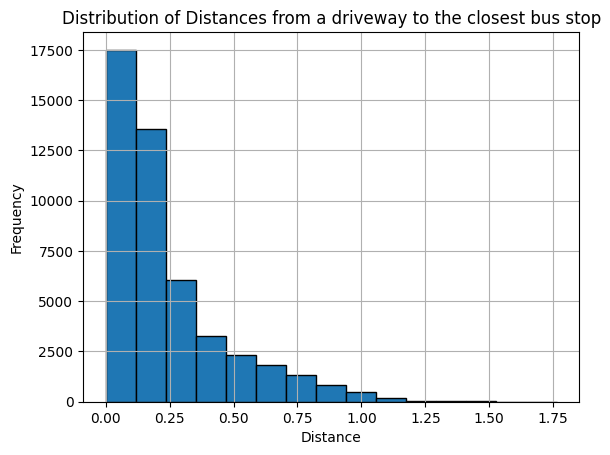

In [22]:
#SAME WITH THIS, DON'T RUN. ONLY FOR VISUALIZING THAT THE NEW STOPS ARE CORRECT

driveway_to_bus['distance'].hist(bins=15, edgecolor='black')
plt.title('Distribution of Distances from a driveway to the closest bus stop')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

Given all the new stops are on the edge of the city, and all the existing routes are mostly in the middle, we won't try to join the new stops to the existing routes, but instead will just add them as new routes. Lets see exactly how far those new stops are from the existing routes anyways.

In [23]:
import geopy.distance

routes = routes.dropna(subset=['geo_point_2d'])

def calculate_distance(coord1, coord2):
    # Calculate distance between two sets of coordinates using the Haversine formula
    return geopy.distance.distance(coord1, coord2).kilometers

new_stops_df = pd.DataFrame(columns=['stop_long', 'stop_lat', 'closest_route_long', 'closest_route_lat', 'distance', 'route_id'])
for k, stop in enumerate(new_stops):
    min_dist = 100000
    closest_route = None
    for route in coordinates:
        for i in range(len(route)-1):
            dist = calculate_distance(stop, route[i])
            if dist < min_dist:
                closest_route = route[i]
                min_dist = dist
                matching_routes = routes[routes['Shape'].str.contains((str(closest_route[1]) + ', ' + str(closest_route[0])))]
                if not matching_routes.empty:
                    route_id = matching_routes.index[0]
                else:
                    route_id = None  # or some other default value
    new_stops_df.loc[k] = [stop[0], stop[1], closest_route[0], closest_route[1], min_dist, route_id]
new_stops_df['route_id'] = new_stops_df['route_id'].astype(int)


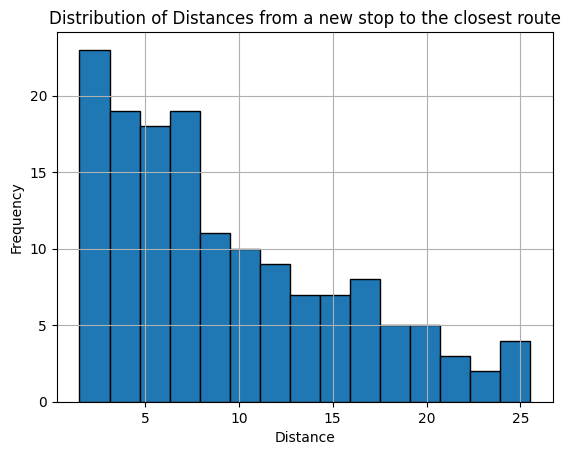

In [24]:
new_stops_df['distance'].hist(bins=15, edgecolor='black')
plt.title('Distribution of Distances from a new stop to the closest route')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

This is interesting - many stops are fairly close to existing routes. It would likely be very difficult to try to merge them though, given visually, the new stops are quite out of the way. Let's try to cluster the new stops into new routes. We'll use the k-means clustering algorithm to do this.

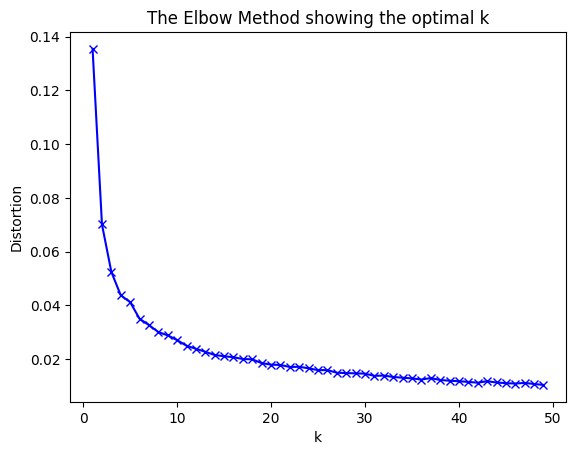

In [25]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Assume 'df' is your DataFrame and it has two columns 'latitude' and 'longitude'
coordinates_from_df = new_stops_df[['stop_lat', 'stop_long']]

# k means determine k
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(coordinates_from_df)
    kmeanModel.fit(coordinates_from_df)
    distortions.append(sum(np.min(cdist(coordinates_from_df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / coordinates_from_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Here, we can see that the elbow is at roughly 10 clusters, however we must keep in mind that there are 150 stops, and given they are all quite spread out, it may make sense to opt for more clusters, as if there are too many stops per route, especially given they all need to go downtown, then the routes will take too long, and people will be less likely to use the bus. Let's try 20 clusters.

In [26]:
from sklearn.cluster import KMeans

# Specify the number of clusters
k = 20

# Perform k-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(coordinates_from_df)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to your DataFrame
new_stops_df['cluster'] = labels

In [27]:
map = folium.Map(location=(new_stops_df.iloc[0]['stop_long'], new_stops_df.iloc[0]['stop_lat']))
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
          'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
          'gray', 'black', 'lightgray', 'yellow']

for _, row in new_stops_df.iterrows():
    color = colors[int(row['cluster'])]
    folium.Marker((row['stop_long'], row['stop_lat']), icon=folium.Icon(color=color)).add_to(map)

map

/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/2089576653.py:9: UserWarning: color argument of Icon should be one of: {'red', 'pink', 'darkgreen', 'gray', 'darkblue', 'lightred', 'black', 'purple', 'lightgreen', 'darkred', 'lightblue', 'darkpurple', 'blue', 'beige', 'orange', 'lightgray', 'cadetblue', 'green', 'white'}.
  folium.Marker((row['stop_long'], row['stop_lat']), icon=folium.Icon(color=color)).add_to(map)


This appears to be a good number of clusters. Lets figure out the route for each cluster, using the travelling salesman problem. Given I have some time, I figured I'd try out what we learned in CISC 455, and use a genetic algorithm.

In [28]:
# from scipy.spatial.distance import pdist, squareform
# from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import haversine_distances
# from math import radians
from deap import creator, base, tools, algorithms
import random
from functools import partial
def generate_tsp_routes_genetic_non_threaded():
    tsp_routes = {}

    # Define the fitness and individual classes
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()

    for cluster in new_stops_df['cluster'].unique():
        cluster_df = new_stops_df[new_stops_df['cluster'] == cluster].reset_index(drop=True)
        min_distance_idx = cluster_df['distance'].idxmin()
        
        # Calculate the distance matrix using haversine_distances
        rad_long = np.radians(cluster_df['stop_long'])
        rad_lat = np.radians(cluster_df['stop_lat'])

        distance_matrix = haversine_distances(
            np.array([rad_long, rad_lat]).T
        )

        def create_individual(toolbox, start_index, n):
            indices = list(range(n))
            # indices.remove(start_index)
            # return [start_index] + toolbox.indices(indices)
            return toolbox.indices(indices)

        def custom_mutShuffleIndexes(individual, indpb):
            for i in range(1, len(individual)):
                if random.random() < indpb:
                    swap_indx = random.randint(1, len(individual) - 2)
                    individual[i], individual[swap_indx] = individual[swap_indx], individual[i]
            return individual,

        def create_indices(indices):
            return random.sample(indices, len(indices))

        # Define the gene and individual creation operations
        toolbox.register("indices", create_indices)

        n = len(distance_matrix)
        start_index = min_distance_idx
        partial_create_individual = partial(create_individual, toolbox=toolbox, start_index=start_index, n=n)

        toolbox.register("individual", tools.initIterate, creator.Individual, partial_create_individual)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        # Define the evaluation function
        def evalTSP(individual):
            distance_sum = sum(distance_matrix[i][j] for i, j in zip(individual[:-1], individual[1:]))
            distance_sum += distance_matrix[individual[-1]][individual[0]]
            return distance_sum,

        toolbox.register("evaluate", evalTSP)

        # Define the mutation operation
        toolbox.register("mutate", custom_mutShuffleIndexes, indpb=0.05)

        # Define the crossover operation
        toolbox.register("mate", tools.cxOrdered)

        # Define the selection operation
        toolbox.register("select", tools.selTournament, tournsize=3)

        # Create the initial population
        pop = toolbox.population(n=500)

        # Run the genetic algorithm
        result, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=2000, verbose=False)

        # Extract the best individual from the result
        best_individual = tools.selBest(result, k=1)[0]

        # The best route is the order of the stops in the best individual
        best_route = cluster_df.iloc[best_individual]

        # Add the best route to the tsp_routes dictionary
        tsp_routes[cluster] = best_route
    return tsp_routes

def generate_tsp_routes_genetic(cluster_df, cluster):
    tsp_routes = {}

    # Define the fitness and individual classes
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()

    # for cluster in new_stops_df['cluster'].unique():
        # cluster_df = new_stops_df[new_stops_df['cluster'] == cluster].reset_index(drop=True)
    min_distance_idx = cluster_df['distance'].idxmin()
    
    # Calculate the distance matrix using haversine_distances
    rad_long = np.radians(cluster_df['stop_long'])
    rad_lat = np.radians(cluster_df['stop_lat'])

    distance_matrix = haversine_distances(
        np.array([rad_long, rad_lat]).T
    )

    def create_individual(toolbox, start_index, n):
        indices = list(range(n))
        # indices.remove(start_index)
        # return [start_index] + toolbox.indices(indices)
        return toolbox.indices(indices)

    def custom_mutShuffleIndexes(individual, indpb):
        for i in range(1, len(individual)):
            if random.random() < indpb:
                swap_indx = random.randint(1, len(individual) - 2)
                individual[i], individual[swap_indx] = individual[swap_indx], individual[i]
        return individual,

    def create_indices(indices):
        return random.sample(indices, len(indices))

    # Define the gene and individual creation operations
    toolbox.register("indices", create_indices)

    n = len(distance_matrix)
    start_index = min_distance_idx
    partial_create_individual = partial(create_individual, toolbox=toolbox, start_index=start_index, n=n)

    toolbox.register("individual", tools.initIterate, creator.Individual, partial_create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Define the evaluation function
    def evalTSP(individual):
        distance_sum = sum(distance_matrix[i][j] for i, j in zip(individual[:-1], individual[1:]))
        distance_sum += distance_matrix[individual[-1]][individual[0]]
        return distance_sum,

    toolbox.register("evaluate", evalTSP)

    # Define the mutation operation
    toolbox.register("mutate", custom_mutShuffleIndexes, indpb=0.05)

    # Define the crossover operation
    toolbox.register("mate", tools.cxOrdered)

    # Define the selection operation
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Create the initial population
    pop = toolbox.population(n=500)

    # Run the genetic algorithm
    result, log = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=2000, verbose=False)

    # Extract the best individual from the result
    best_individual = tools.selBest(result, k=1)[0]

    # The best route is the order of the stops in the best individual
    best_route = cluster_df.iloc[best_individual]

    # Add the best route to the tsp_routes dictionary
    tsp_routes[cluster] = best_route
    return tsp_routes


tsp_routes = generate_tsp_routes_genetic_non_threaded()
    

That took a really long time, so given there's only 150 stops, I'll just use brute force.

In [29]:
import itertools

def generate_tsp_routes_held_karp(cluster_df, cluster):
    def held_karp(distances):
        n = len(distances)

        # Maps each subset of the nodes to the cost to reach that subset, as well
        # as what node it passed before reaching this subset.
        # Node subsets are represented as set bits.
        C = {}

        # Set transition cost from initial state
        for k in range(1, n):
            C[(1 << k, k)] = (distances[0][k], 0)

        # Iterate subsets of increasing length and store intermediate results
        # in classic dynamic programming manner
        for subset_size in range(2, n):
            for subset in itertools.combinations(range(1, n), subset_size):
                # Set bits for all nodes in this subset
                bits = 0
                for bit in subset:
                    bits |= 1 << bit

                # Find the lowest cost to get to this subset
                for k in subset:
                    prev = bits & ~(1 << k)

                    res = []
                    for m in subset:
                        if m == 0 or m == k:
                            continue
                        res.append((C[(prev, m)][0] + distances[m][k], m))
                    C[(bits, k)] = min(res)

        # We're interested in all bits but the least significant (the start state)
        bits = (2**n - 1) - 1

        # Calculate optimal cost
        res = []
        for k in range(1, n):
            res.append((C[(bits, k)][0] + distances[k][0], k))
        opt, parent = min(res)

        # Backtrack to find full path
        path = []
        for i in range(n - 1):
            path.append(parent)
            new_bits = bits & ~(1 << parent)
            _, parent = C[(bits, parent)]
            bits = new_bits

        # Add implicit start state
        path.append(0)

        return opt, list(reversed(path))

    tsp_routes = {}
    # for cluster in new_stops_df['cluster'].unique():
    print("cluster:", cluster)
    # cluster_df = new_stops_df[new_stops_df['cluster'] == cluster].reset_index(drop=True)
    min_distance_idx = cluster_df['distance'].idxmin()

    # Calculate the distance matrix using haversine_distances
    rad_long = np.radians(cluster_df['stop_long'])
    rad_lat = np.radians(cluster_df['stop_lat'])

    distance_matrix = haversine_distances(
        np.array([rad_long, rad_lat]).T
    )

    best_route_distance, best_route_indices = held_karp(distance_matrix)
    tsp_routes[cluster] = cluster_df.iloc[best_route_indices]
    return tsp_routes

# tsp_routes = generate_tsp_routes_held_karp()

In [30]:
map = folium.Map(location=(new_stops_df['stop_long'].mean(), new_stops_df['stop_lat'].mean()))
for cluster, route in tsp_routes.items():
    # break
    color = colors[int(cluster) % len(colors)]
    cur_coords = route[['stop_long', 'stop_lat']].values.tolist()
    cur_coords.append(cur_coords[0])
    folium.PolyLine(cur_coords, color=color).add_to(map)
    # # Add a marker for the start index
    # start = route.iloc[route['distance'].idxmin()]
    # folium.Marker(location=[start['stop_long'], start['stop_lat']], popup='Start', icon=folium.Icon(color='green')).add_to(map)

    for index, stop in route.iterrows():
        # if index != start.name:  # Skip the start index
        folium.Marker(location=[stop['stop_long'], stop['stop_lat']], icon=folium.Icon(color=color)).add_to(map)

map

/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/4184461193.py:14: UserWarning: color argument of Icon should be one of: {'red', 'pink', 'darkgreen', 'gray', 'darkblue', 'lightred', 'black', 'purple', 'lightgreen', 'darkred', 'lightblue', 'darkpurple', 'blue', 'beige', 'orange', 'lightgray', 'cadetblue', 'green', 'white'}.
  folium.Marker(location=[stop['stop_long'], stop['stop_lat']], icon=folium.Icon(color=color)).add_to(map)


Displayed above are the routes we came up with. Now, lets see how much gas is saved.  We'll assume that everybody is going to the downtown transfer point. ourworldindata.org says the average car produces 170 grams of CO2 per kilometer.

In [37]:
test_route = routes[routes['ID'] == "501"]['Shape'].iloc[0]
test_route = json.loads(test_route)['coordinates'][0]
test_route = [(y, x) for [x, y] in test_route]

transfer_point = test_route[-1] #downtown transfer point

far_driveways = driveway_to_bus[driveway_to_bus['distance'] > 1.5] #find people who otherwise would be driving
print(far_driveways.shape)

total_distance = 0
for index, row in far_driveways.iterrows():
    driveway_coords = (row['driveway_long'], row['driveway_lat'])
    distance = geopy.distance.distance(driveway_coords, transfer_point).km
    total_distance += distance
    

total_distance *= 2 #round trip
total_distance *= 2 #cars per driveway

co2_car = total_distance * 0.17 #kg of CO2 per km
print(co2_car)

(6696, 5)
59942.32099543352


Now that we have the total CO2 burned, we need to figure out how much CO2 would be burned if everybody took the bus. carbonindependent.org says an average bus uses 822 grams of CO2 per kilometer. Lets say each bus will go from the transfer point to the green point loop the route, and back, 5x per day. There will be 5 buses per route.

In [39]:
def get_distance_and_co2(routes):
    distance_per_route = []
    for cluster, route in routes.items():
        total_distance = 0
        route['distance_to_transfer'] = route.apply(lambda row: geopy.distance.distance((row['stop_long'], row['stop_lat']), transfer_point).km, axis=1)
        start = route.loc[route['distance_to_transfer'].idxmin()]
        distance_to_transfer = geopy.distance.distance((start['stop_long'], start['stop_lat']), transfer_point).km
        total_distance += distance_to_transfer
        last_stop = start
        for index, stop in route.iterrows():
            if index != start.name: #skip the start index
                cur_distance = geopy.distance.distance((last_stop['stop_long'], last_stop['stop_lat']), (stop['stop_long'], stop['stop_lat'])).km
                total_distance += cur_distance
                last_stop = stop
        total_distance += distance_to_transfer #go back to transfer point
        distance_per_route.append(total_distance)

    total_distance = sum(distance_per_route)
    total_distance *= 5 #5 buses per route
    total_distance *= 5 #each bus makes 5 trips per day
    co2_bus = total_distance * 0.822 #kg of CO2 per km
    return distance_per_route, co2_bus

distance_per_route, co2_bus = get_distance_and_co2(tsp_routes)
print(np.average(distance_per_route), co2_bus)
print(co2_car - co2_bus)
    

38.399191363857916 15782.067650545601
44160.25334488792


So we can see that the bus routes will save over 44,000 kg of CO2 per day. Let's see what happens if we recombine the routes into several different values, and see how that changes our average distance and CO2 saved.

In [40]:
from joblib import Parallel, delayed

def process_cluster(cluster, k):
    # Extract the stops for this cluster
    cluster_df = new_stops_df[new_stops_df['cluster'] == cluster]

    # Generate the TSP route for this cluster
    if (k > 15):
        tsp_route = generate_tsp_routes_held_karp(cluster_df, cluster)
    else:
        tsp_route = generate_tsp_routes_genetic(cluster_df, cluster)

    # Compute the distance and CO2 for this route
    distance_per_route, co2_bus = get_distance_and_co2(tsp_route)

    return tsp_route, distance_per_route, co2_bus

distances = {}
co2 = {}
all_routes = {}

for k in range(5, 21):
    print(k)
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(coordinates_from_df)

    # Get the cluster labels for each data point
    labels = kmeans.labels_

    # Add the cluster labels to your DataFrame
    new_stops_df['cluster'] = labels

    # Process each cluster in parallel
    results = Parallel(n_jobs=-1)(delayed(process_cluster)(cluster, k) for cluster in range(k))

    # Unpack the results
    tsp_routes, distance_per_route, co2_bus = zip(*results)
    

    all_routes[k] = tsp_routes
    distances[k] = distance_per_route
    co2[k] = co2_bus

5


/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

6


rary/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library

7


/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

8


/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

9


/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' h

10


/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' h

11


/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' h

12


/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' h

13


/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' h

14


/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' h

15


/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' h

16
cluster: 1
cluster: 0
cluster: 2
cluster: 3
cluster: 4
cluster: 5
cluster:cluster: 7
 6
cluster: 8
cluster: 9
cluster: 10
cluster: 11
cluster: 12
cluster: 13
cluster: 14
cluster: 15
17
cluster: 0
cluster: 1
cluster: 2
cluster: 3
cluster: 4
cluster: 5
cluster: 6
cluster: 7
cluster: 8
cluster: 9
cluster: 10
cluster: 11
cluster: 12
cluster: 13
cluster: 14
cluster: 15
cluster: 16
18
cluster: 0
cluster: 1
cluster: 2
cluster: 3
cluster: 4
cluster: 5
cluster: 6
cluster: 7
cluster: 8
cluster: 9
cluster: 10
cluster: 11
cluster: 12
cluster: 13
cluster: 14
cluster: 15
cluster: 16
cluster: 17
19
cluster: 0
cluster: 1
cluster: 2
cluster: 3
cluster: 4
cluster: 5
cluster: 6
cluster: 7
cluster: 8
cluster: 9
cluster: 10
cluster: 11
cluster: 12
cluster: 13
cluster: 14
cluster: 15
cluster: 16
cluster: 17
cluster: 18
20
cluster: 0
cluster: 1
cluster: 2
cluster: 3
cluster: 4
cluster: 5
cluster: 6
cluster: 7
cluster: 8
cluster: 9
cluster: 10
cluster: 11
cluster: 12
cluster: 13
cluster: 14
cluster: 15
clu

/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_6452/3378749994.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [47]:
tsp_routes = all_routes[10]
colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'darkred',
]
def draw_map(tsp_routes):
    map = folium.Map(location=(new_stops_df['stop_long'].mean(), new_stops_df['stop_lat'].mean()))
    for cluster, route in enumerate(tsp_routes):
        route = route[cluster]
        color = colors[int(cluster) % len(colors)]
        cur_coords = route[['stop_long', 'stop_lat']].values.tolist()
        cur_coords.append(cur_coords[0])
        # cur_coords.append(transfer_point)
        folium.PolyLine(cur_coords, color=color).add_to(map)
        # # Add a marker for the start index
        # start = route.iloc[route['distance'].idxmin()]
        # folium.Marker(location=[start['stop_long'], start['stop_lat']], popup='Start', icon=folium.Icon(color='green')).add_to(map)

        # for index, stop in route.iterrows():
        #     # if index != start.name:  # Skip the start index
        #     folium.Marker(location=[stop['stop_long'], stop['stop_lat']], icon=folium.Icon(color=color)).add_to(map)
    return map


If you'd like to see all the routes on a map, run the next cell.

In [ ]:
from IPython.display import display

for i in range(5, 21):
    display(draw_map(all_routes[i]))

In [42]:
average_distances = []
total_co2 = []
for i in range(5, 21):
    flat_distances = [num for sublist in distances[i] for num in sublist]
    print("k =", i)
    print("average distance:", sum(flat_distances)/len(flat_distances))
    average_distances.append(sum(flat_distances)/len(flat_distances))
    print("Total CO2:", sum(co2[i]))
    total_co2.append(sum(co2[i]))
    print()

k = 5
average distance: 75.31773150581236
Total CO2: 7738.8969122222215

k = 6
average distance: 65.40885321786347
Total CO2: 8064.911601762564

k = 7
average distance: 60.21753695023691
Total CO2: 8662.292690291579

k = 8
average distance: 56.48785309195108
Total CO2: 9286.603048316758

k = 9
average distance: 52.4983870578564
Total CO2: 9709.57668635054

k = 10
average distance: 52.56428981770254
Total CO2: 10801.961557537872

k = 11
average distance: 46.88674604421922
Total CO2: 10598.748943295755

k = 12
average distance: 48.73503964596683
Total CO2: 12018.060776695422

k = 13
average distance: 46.98425318379181
Total CO2: 12551.84323804998

k = 14
average distance: 45.22962539466842
Total CO2: 13012.563226046106

k = 15
average distance: 43.24206966128493
Total CO2: 13329.367973091079

k = 16
average distance: 41.50588171337396
Total CO2: 13647.133907357356

k = 17
average distance: 39.76422416321911
Total CO2: 13891.631711420598

k = 18
average distance: 39.19549667383401
Total C

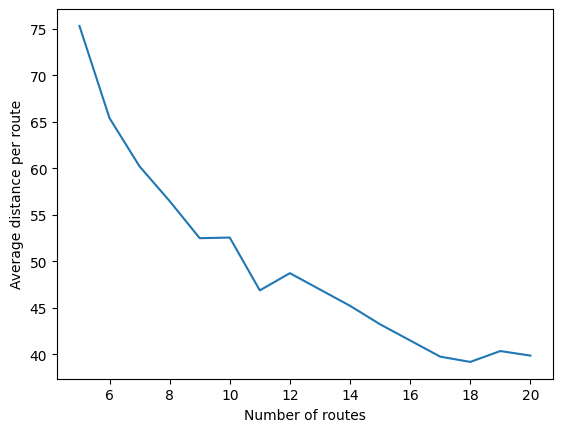

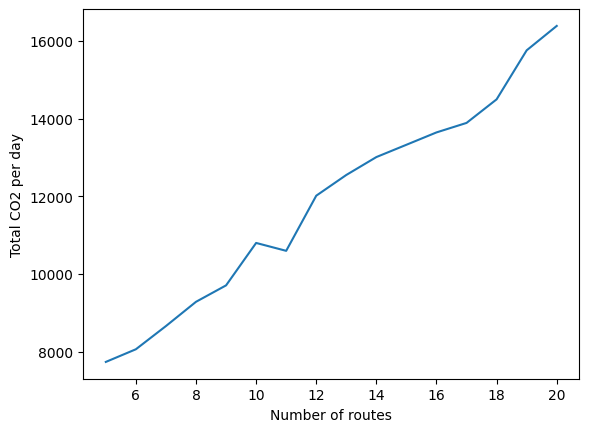

In [43]:
x = list(range(5, 21))

plt.figure()
plt.plot(x, average_distances,label = "Average Distance per Route")

plt.xlabel("Number of routes")
plt.ylabel("Average distance per route")
# plt.legend()
plt.show()

plt.figure()
plt.plot(x, total_co2, label = "Total CO2 per day")
plt.xlabel("Number of routes")
plt.ylabel("Total CO2 per day")
# plt.legend()
plt.show()



We know that most people aren't going to be using the bus if it's significantly slower than taking a car, and so I think that we found a happy medium with 13 routes. On our graph, there is a divot at that point, reducing the average distance per route, therefore reducing the average time per route, while still saving a lot of CO2.

13 routes also gives us an average distance of roughly 45km per route, and if a bus travels at 40km/h, that means it will take roughly 30 minutes to get downtown, which is a reasonable amount of time for people to be willing to take the bus.

Lets find out exactly how much CO2 we'll save per year. Let's also take a look at the final routes.

In [48]:
draw_map(all_routes[11])

In [49]:
(co2_car - total_co2[11-5])*365

18010403.799030285

This means, that if everybody used new bus routes, we would save over 
17,000,000 kg of CO2 per year, in Kingston alone. Given that the routes are in straight lines, there will obviously be more distance required, however that holds true for the drivers as well, so it would either cancel out, or make the bus routes even more efficient.